# Analyzing User-Video Interaction Networks for Disinformation and Astroturfing Patterns in White Helmets-Related Content

Ludwig Schulte, Skyler Johnson

## Abstract

Disinformation campaigns and astroturfing are increasingly employed to manipulate public opinion. This exercise examines the structure of a user-video interaction network centered on White Helmets-related content, in response to their involvement in the Syrian civil war. Using the NetworkX library, we built a baseline network to model user interactions with these videos, followed by comparison with two synthetic network models (Watts-Strogatz and Barabási-Albert) that simulate typical social media structures. By evaluating metrics like clustering coefficient, transitivity, degree assortativity, and modularity, we identify network characteristics that may suggest coordinated inauthentic behavior, such as tightly-knit user clusters or centralized hubs indicative of astroturfing. This approach offers insights into recognizing coordinated influence within networks focused on sensitive or targeted content.

## Introduction

Coordinated disinformation campaigns and astroturfing employ various methods to influence public perception on sensitive issues, including by making orchestrated narratives appear organically generated. The White Helmets, a humanitarian group active in conflict areas, has been the subject of targeted online disinformation. Detecting structural patterns within user interactions around White Helmets content may reveal clues to inauthentic or coordinated behavior.
Herein, we construct a baseline user-video interaction network focused on White Helmets-related content. By comparing this baseline network to two model-generated networks, we identify features that may suggest signs of coordinated activity, such as high clustering, community modularity, or centralized influence. These comparative methods allow us to assess whether distinct network patterns emerge within the White Helmets content, which may help identify and understand disinformation or astroturfing.

## Methods
Data Preprocessing and Cleaning
The dataset, pairwise_52seconds_share.csv, consists of pairwise interactions between users and videos related to the White Helmets. Each entry represents a user-video interaction or a user-user connection through a shared video, along with timestamps. We loaded the dataset into a pandas DataFrame for preprocessing.
Using NetworkX, we created a graph G to model user interactions. Nodes represent users and videos, with edges denoting user interactions with videos or with each other through shared video engagement. To ensure data integrity, duplicate connections and self-loops were removed. The following code block demonstrates the network construction process.


First, we need to read the data into a network that can be read by gephi, using networkx. We create nodes for each user and video and connect them via edges for each entry in the table (as each entry consists of a 'triangle'). Of course, we do not want any duplicates or self loops. We can then, using notworkx, write the data to a gexf file, which can be read by gephi.

In [55]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

df = pd.read_csv('pairwise_52seconds_share.csv')

G = nx.Graph()

for _, row in df.iterrows():
    user_1 = f"user_{row['userID_1']}"
    user_2 = f"user_{row['userID_2']}"
    video_node = f"video_{row['videoID']}"
    
    if not G.has_node(user_1):
        G.add_node(user_1, type='user', color='blue')
    
    if not G.has_node(user_2):
        G.add_node(user_2, type='user', color='blue')
        
    if not G.has_node(video_node):
        G.add_node(video_node, type='video', color='green')
        
    G.add_edge(user_1, video_node, timestamp=row['timestamp_1'])
    G.add_edge(user_2, video_node, timestamp=row['timestamp_2'])
    G.add_edge(user_2, user_1, timestamp=row['timestamp_1'])
    
G.remove_edges_from(nx.selfloop_edges(G))

In [56]:
nx.write_gexf(G, "white_helm.gexf")


Using the number of nodes and edges from the base network, we can then generate various other network types, to compare them to the base network. We choose here a watts strogatz model and a barabasi albert model, as both of these simulate the social media structure that we are expecting from the base network, and in which we want to find irregularities. The parameters here are easily imputed from the base network, k (for watts strogatz) is simply the average amound of connections per node in the base network (2m/n), and p is set to 0.1. This is the same for barabasi-albert too.
We can then generate graphs for the network using gephi, utilising clustering algorithms like ForceAtlas2. This generates the following graph for our white helm data network:

![White helm network](white_helm.png)

In [85]:
n = G.number_of_nodes()
m = G.number_of_edges()

k = int((2 * m) / n)

H = nx.watts_strogatz_graph(n= n, k = k, p = 0.1)

nx.write_gexf(H, "watts_strogatz_random.gexf")

We then generate a watts strogatz graph, using the metrics defined above, yielding the following network:

![watts strogatz network](watts_strogatz.png)

With higher values for p, the network becomes less circular and more 'stringy'. An example of this can be seen in the graph below:

![watts strogatz network (p = 0.3)](watts_strogatz2.png)


In [58]:

m_par = k

K = nx.barabasi_albert_graph(n = n, m = m_par)

nx.write_gexf(K, "barabasi_albert.gexf")

we also generate the barabasi albert graph, which looks like this:

![barabasi albert graph](barabasi_albert.png)


We can already see that the structures of the networks are quite different, with the white helm network being very hierarchical with lots of big hub nodes and smaller edge nodes. This is much less expressed in the two random networks, which are more distributed.

We can then define various metrics that we would like to assess for the different networks and apply them to compare.
- 1.	Transitivity: High transitivity may indicate dense clustering, which suggests coordinated networks.
- 2.	Degree Assortativity: Low or negative assortativity may signify isolated, low-degree nodes linked to central hubs, potentially indicating artificial accounts.
- 3.	Diameter and Average Shortest Path: Small diameters in the White Helmets network could indicate high connectivity due to coordinated sharing.
- 4.	Average Shortest Path: Similar to diameter, shorter average paths indicate higher connectivity.
- 5.	Modularity: High modularity in community clustering suggests that groups of users might be tightly coordinating.

Average Degree is presented as well, to establish a baseline of centralization within each network. As this is effectively a parameter in the creation of both synthetic networks, its value as a diagnostic tool is in its ability to contextualize other metrics. We also created some plots to visualise the distribution of degrees and betweenness centrality in the network.


In [82]:
# make sure to import python_louvain, not community
import community.community_louvain as community_louvain

# find triangles
def transitivity(net):
    return nx.transitivity(net)

# this one doesnt work for some reason
def rich_club(net):
        largest_cc = max(nx.connected_components(net), key=len)
        net_sub = net.subgraph(largest_cc)
        return nx.rich_club_coefficient(net_sub)

# average node degree (we might wanna make plots here to see how the degree varies in a curve, see below)
def average_degree(net):
    return sum(dict(net.degree()).values()) / net.number_of_nodes()

# dont put this in the compare network function
def plot_degree(net):
    degrees = [d for n, d in net.degree()]
    plt.hist(degrees, log = True)
    plt.title('Degree Distribution')
    plt.xlabel('Degree')
    plt.ylabel('Frequency')
    plt.show()

# this shows if nodes of similar degrees are connected (-1 to 1)
def deg_assortativity(net):
    return nx.degree_assortativity_coefficient(net)

# how likely are nodes neighbors also connected
def clustering_coefficient(net):
    return nx.average_clustering(net)

def diameter(net):
        largest_cc = max(nx.connected_components(net), key=len)
        net_sub = net.subgraph(largest_cc)
        return nx.diameter(net_sub)

def avg_shortest_path(net):
        largest_cc = max(nx.connected_components(net), key=len)
        net_sub = net.subgraph(largest_cc)
        return nx.average_shortest_path_length(net_sub)

# this is for whether the network is easily divisible into communities (densely connected sub areas) (between 0 and 1)
def modularity(net):
    partition_dict = community_louvain.best_partition(net)
    partition = []
    for community_id in set(partition_dict.values()):
        community_nodes = [node for node, community in partition_dict.items() if community == community_id]
        partition.append(community_nodes)
    return nx.algorithms.community.modularity(net, partition)

# related to this (also dont put this in the compare network function)
def plot_betweenness_centrality(net):
    betweenness = nx.betweenness_centrality(net)
    vals = list(betweenness.values())
    plt.hist(vals, log = True)
    plt.title('Betweenness Centrality Distribution')
    plt.xlabel('Betweenness Centrality')
    plt.ylabel('Frequency')
    plt.show()
    
def plot_betweenness_centraliy_mult(nets):
    n = len(nets)
    fig, axs = plt.subplots(1, n, figsize=(5 * n, 4), squeeze=False) 
    
    for i, net in enumerate(nets):
        betweenness = nx.betweenness_centrality(net)
        vals = list(betweenness.values())
        
        axs[0, i].hist(vals, bins=20, alpha=0.7, log=True)
        axs[0, i].set_title(f'Network {i+1}')
        axs[0, i].set_xlabel('Betweenness Centrality')
        axs[0, i].set_ylabel('Frequency')
    
    plt.suptitle('Betweenness Centrality Distributions')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  
    plt.show()

def plot_deg_mult(nets):
    n = len(nets)
    fig, axs = plt.subplots(1, n, figsize=(5 * n, 4), squeeze=False) 
    for i, net in enumerate(networks):
        degrees = [d for n, d in net.degree()]
        
        axs[0, i].hist(degrees, bins=20, log=True, alpha=0.7)
        axs[0, i].set_title(f'Network {i+1}')
        axs[0, i].set_xlabel('Degree')
        axs[0, i].set_ylabel('Frequency (log scale)')
    
    plt.suptitle('Degree Distributions Across Networks')
    plt.tight_layout(rect=(0, 0.03, 1, 0.95))  
    plt.show()

In [60]:
def compare_networks(net, base_networks):
    metrics = [transitivity, average_degree, deg_assortativity, diameter, avg_shortest_path, modularity]
    metric_names = [metric.__name__ for metric in metrics]
    
    results = {metric_name: [] for metric_name in metric_names}
    networks = [('blue_helm', net)] + [(f'baseline{i+1}', base_net) for i, base_net in enumerate(base_networks)]
    
    for name, network in networks:
        for metric in metrics:
            results[metric.__name__].append(metric(network))
            
    return results
    

In [88]:

result = compare_networks(G, [H, K])

## Results
We can show the results by just printing this dictionary. The metrics are in the same order as the input in the compare networks function input (so white helmet, then watts strogatz, then barabasi albert).

In [90]:
result

{'transitivity': [0.010092078570901202, 0, 0.005204094090835097],
 'average_degree': [3.8392857142857144, 2.0, 5.9958791208791204],
 'deg_assortativity': [-0.14743884690490577,
  -0.07680005517741138,
  -0.03754874147158474],
 'diameter': [17, 220, 7],
 'avg_shortest_path': [4.771102215238985,
  85.55188971949649,
  4.049053905791941],
 'modularity': [0.8117180955713218, 0.9688403853281944, 0.3884720274097663]}

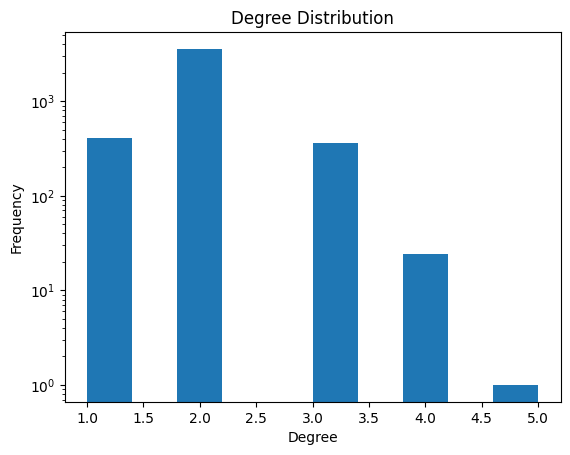

In [81]:
plot_degree(H)

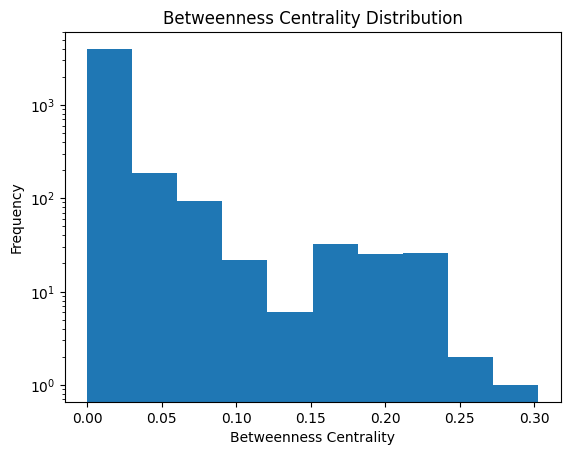

In [87]:
plot_betweenness_centrality(H)

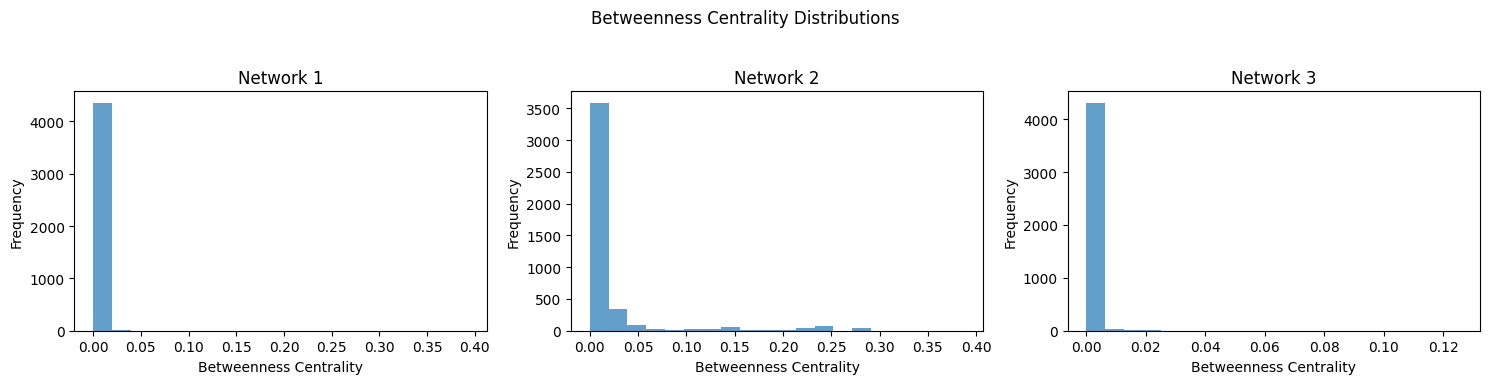

In [74]:
networks = [G,H,K]

plot_betweenness_centraliy_mult(networks)

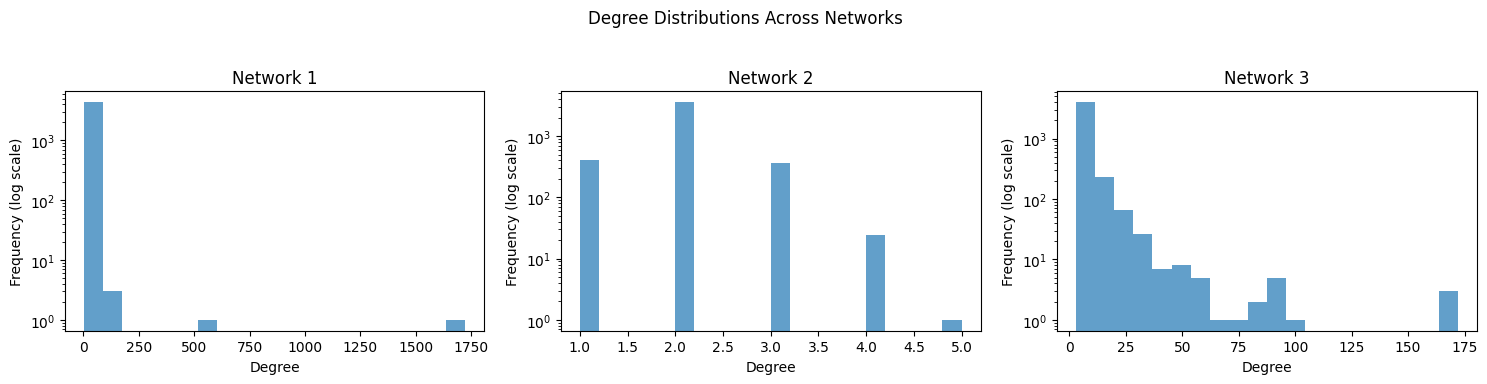

In [86]:
plot_deg_mult(networks)

## Discussion
The White Helmets network exhibits several key differences from the model networks, indicative of disinformation or astroturfing behavior. The clustering, high modularity, and low assortativity suggest potential coordination where small communities of users engage with content in ways that appear organically generated but may actually be orchestrated.
### Indicators of Disinformation and Astroturfing
- 1.	High Modularity and Clustering: High modularity points coordinated user behavior. It is our belief that, given the timeframe between posts, this is unlikely to originate organically. Observed modularity was only slightly lower than that of the Watts-Strogatz model, which deliberately generated disparate local clusters, and significantly higher than that of Barabási–Albert.
- 2.	Low Degree Assortativity: The low assortativity in G compared to model networks suggests centralized hubs with many isolated nodes.
- 3.	Increased Centralization: A smaller diameter in G compared to the Watts Strogatz model indicates potential astroturfing, where central nodes disseminate content widely.
As our synthetic models varied wildly in average shortest path length and diameter, we were unable to make meaningful inferences from comparing these to our dataset.
- 4.	Low Betweenness Centrality: The low betweenness centrality in G compared to the Watts Strogatz model suggests centralized hubs with many isolated nodes. This compares closely to the barabasi albert model, which also has a lot of disseminated nodes, but is quite different from the watts strogatz model, which has more central nodes.
- 5. lastly, if we look at the distribution in node degree, we can see that the white helmet dataset has a much longer, but also smaller tail compared to the other two models. This indicated that in that dataset specifically, there are few very highly connected nodes, which is indicative of astroturfing, as few videos are shared in a very short timeframe by a large number of users.

### Limitations
While the synthetic models (Watts-Strogatz and Barabási-Albert) effectively simulate certain structural features of social networks, they do not fully capture the dynamics of authentic, grassroots engagement. Without a real-world baseline network free from disinformation influence, it remains challenging to establish definitive markers of coordinated inauthentic behavior. Future work should incorporate either a validated dataset on a similarly contentious topic without known disinformation or leverage established heuristics on organic network behavior specific to the dataset's topic. This would allow for a more precise differentiation between organic and manipulated interactions in our analyses.

## Conclusion
This study explores the structure of user interactions with White Helmets-related content, identifying potential signs of coordinated disinformation campaigns and astroturfing. By comparing this network to model-based benchmarks, we demonstrate how network metrics can help uncover patterns associated with orchestrated influence operations. This approach underscores the utility of network analysis in combatting disinformation and enhancing the credibility of social media platforms.
